# Simulation

We can bring together the detector and source modelling to calculate the expected number of neutrino events and run simulations.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
import h5py

## Defining a source and detector model

In [2]:
from icecube_tools.detector.effective_area import EffectiveArea
from icecube_tools.detector.energy_resolution import EnergyResolution
from icecube_tools.detector.angular_resolution import AngularResolution
from icecube_tools.detector.detector import IceCube
from icecube_tools.source.flux_model import PowerLawFlux
from icecube_tools.source.source_model import DiffuseSource, PointSource
from icecube_tools.detector.r2021 import R2021IRF
from icecube_tools.utils.data import SimEvents

In [3]:
# Define detector (see detector model notebook for more info)
aeff = EffectiveArea.from_dataset("20210126", "IC86_II")
irf = R2021IRF.from_period("IC86_II")
# IceCube expects an instance of EffectiveAerea, AngularResolution and
# EnergyResolution, optionally the period (here IC86_I)
# R2021IRF inherits from AngularResolution and EnergyResolution
# just to be able to be used as both
detector = IceCube(aeff, irf, irf, "IC86_II")

In [4]:
# Define simple sources (see source model notebook for more info)
diff_flux_norm = 3e-21  # Flux normalisation in units of GeV^-1 cm^-2 s^-1 sr^-1
point_flux_norm = 5e-19  # Flux normalisation in units of GeV^-1 cm^-2 s^-1
norm_energy = 1e5  # Energy of normalisation in units of GeV
min_energy = 1e2  # GeV
max_energy = 1e8  # GeV

diff_power_law = PowerLawFlux(diff_flux_norm, norm_energy, 3.7, min_energy, max_energy)
diff_source = DiffuseSource(diff_power_law, z=0.0)

point_power_law = PowerLawFlux(
    point_flux_norm, norm_energy, 2.5, min_energy, max_energy
)
point_source = PointSource(point_power_law, z=0.0, coord=(np.pi, np.deg2rad(30)))
sources = [diff_source, point_source]

## Expected number of neutrino events

Sometimes we just want to predict the number of events from sources in a detector without specifying all detector properties or running a simulation. We can do this with the `NeutrinoCalculator`. For this, we just need a source list and an effective area.

In [5]:
from icecube_tools.neutrino_calculator import NeutrinoCalculator, PhiSolver

In [6]:
nu_calc = NeutrinoCalculator(sources, aeff)
nu_calc(
    time=1,  # years
    min_energy=min_energy,
    max_energy=max_energy,  # energy range
    min_cosz=-1,
    max_cosz=1,
)  # cos(zenith) range

[185.18577999134666, 24.51408397397894]

The calculator returns a list of expected neutrino event numbers, one for each source.

We may also want to do the inverse, and find the `PointSource` flux normalisation corresponding to an expected number of events. For this there is the `PhiSolver` class.

In [7]:
phi_solver = PhiSolver(
    aeff, norm_energy, min_energy, max_energy, time=1, min_cosz=-1, max_cosz=1
)
phi_norm = phi_solver(Nnu=15, dec=-30, index=2.0)  # degrees  # spectral index
phi_norm  # GeV^-1 cm^-2 s^-1

/opt/hostedtoolcache/Python/3.9.20/x64/lib/python3.9/site-packages/icecube_tools/neutrino_calculator.py:294: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  phi_norm = fsolve(self._solve_for_phi, x0=guess, args=(Nnu, dec, index))[0]


1.1444338237452659e-17

## Set up and run simulation

In [8]:
from icecube_tools.simulator import Simulator, TimeDependentSimulator

In [9]:
# Set up simulation
simulator = Simulator(sources, detector, "IC86_II")
simulator.time = 1  # year

# Run simulation
simulator.run(show_progress=True, seed=42)

Sampling:   0%|          | 0/204 [00:00<?, ?it/s]

Sampling:   7%|▋         | 15/204 [00:00<00:02, 79.27it/s]

Sampling:  18%|█▊        | 36/204 [00:00<00:01, 134.93it/s]

Sampling:  37%|███▋      | 76/204 [00:00<00:00, 211.60it/s]

Sampling:  79%|███████▉  | 162/204 [00:00<00:00, 418.98it/s]

Sampling: 100%|██████████| 204/204 [00:00<00:00, 232.58it/s]

This way, the simulator calculates the expected number of neutrinos from these sources given the observation period, effective area and relevant source properties. We note that we could also run a simulation for a fixed number of neutrinos if we want, simply by passing the optional argument `N` to `simulator.run()`.

In [10]:
simulator.write_to_h5("h5_test.hdf5", sources)

In [11]:
simulator.arrival_energy

{'IC86_II': array([7.14210028e+02, 3.23388666e+02, 1.80111166e+03, 1.98115885e+02,
        2.30965248e+02, 1.72795141e+02, 5.17489092e+03, 4.40330898e+02,
        1.55148412e+03, 2.65048351e+02, 1.58823383e+02, 1.15940566e+03,
        1.51603933e+02, 1.75155020e+02, 1.03268577e+02, 4.28410295e+02,
        8.98147427e+02, 7.58773870e+02, 6.71234648e+02, 2.58801769e+03,
        3.14632116e+02, 5.38505911e+02, 1.62723177e+03, 2.67854713e+02,
        2.70530741e+02, 9.34743516e+02, 1.81460670e+02, 5.40258039e+02,
        6.55468755e+02, 5.75003650e+02, 1.26075824e+02, 4.85847409e+02,
        2.82589224e+02, 7.96531291e+02, 4.12075792e+02, 3.12642591e+02,
        1.65938649e+03, 6.77278871e+02, 4.99813029e+02, 6.13118787e+02,
        3.37696378e+02, 7.65201578e+02, 5.92951977e+02, 1.23201044e+02,
        1.89469848e+02, 1.13214053e+03, 4.72584760e+02, 1.31327456e+02,
        1.02745485e+03, 4.91791232e+02, 9.44514953e+02, 2.87311325e+03,
        8.21048861e+02, 3.91184938e+02, 4.30137055e+0

In [12]:
events = SimEvents.load_from_h5("h5_test.hdf5")

In [13]:
events.period("IC86_II").keys()

dict_keys(['true_energy', 'reco_energy', 'arrival_energy', 'ang_err', 'ra', 'dec', 'source_label'])

In [14]:
len(events)

1

In [15]:
"""
for i in [1.5, 2.0, 2.5, 3.0, 3.5, 3.7]:
    norm_energy = 1e5 # Energy of normalisation in units of GeV
    min_energy = 1e2 # GeV
    max_energy = 1e8 # GeV
    phi_solver = PhiSolver(aeff, norm_energy, min_energy, max_energy, 
                           time=1, min_cosz=-1, max_cosz=1)
    phi_norm = phi_solver(Nnu=2000, 
                          dec=30, # degrees
                          index=i) # spectral index
    phi_norm # GeV^-1 cm^-2 s^-1
    point_power_law = PowerLawFlux(phi_norm, norm_energy, i, 
                                   min_energy, max_energy)
    point_source = PointSource(point_power_law, z=0., coord=(np.pi, np.deg2rad(30)))
    sources = [point_source]
    simulator = Simulator(sources, detector)
    simulator.time = 1 # year

    # Run simulation
    simulator.run(show_progress=True, seed=42)
    simulator.save(f"data/sim_output_{i:.1f}.h5")
"""

'\nfor i in [1.5, 2.0, 2.5, 3.0, 3.5, 3.7]:\n    norm_energy = 1e5 # Energy of normalisation in units of GeV\n    min_energy = 1e2 # GeV\n    max_energy = 1e8 # GeV\n    phi_solver = PhiSolver(aeff, norm_energy, min_energy, max_energy, \n                           time=1, min_cosz=-1, max_cosz=1)\n    phi_norm = phi_solver(Nnu=2000, \n                          dec=30, # degrees\n                          index=i) # spectral index\n    phi_norm # GeV^-1 cm^-2 s^-1\n    point_power_law = PowerLawFlux(phi_norm, norm_energy, i, \n                                   min_energy, max_energy)\n    point_source = PointSource(point_power_law, z=0., coord=(np.pi, np.deg2rad(30)))\n    sources = [point_source]\n    simulator = Simulator(sources, detector)\n    simulator.time = 1 # year\n\n    # Run simulation\n    simulator.run(show_progress=True, seed=42)\n    simulator.save(f"data/sim_output_{i:.1f}.h5")\n'

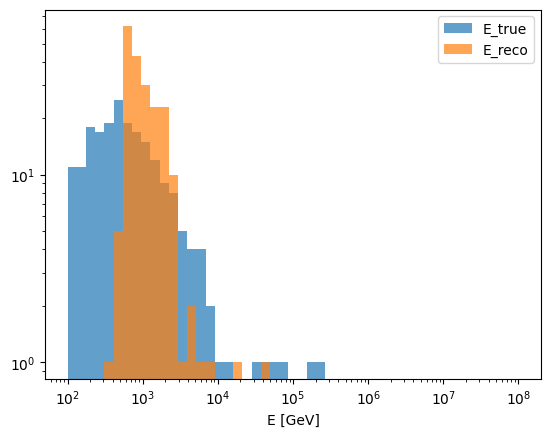

In [16]:
# Plot energies
bins = np.geomspace(1e2, max_energy)
fig, ax = plt.subplots()
ax.hist(events.true_energy["IC86_II"], bins=bins, alpha=0.7, label="E_true")
ax.hist(events.reco_energy["IC86_II"], bins=bins, alpha=0.7, label="E_reco")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("E [GeV]")
ax.legend()

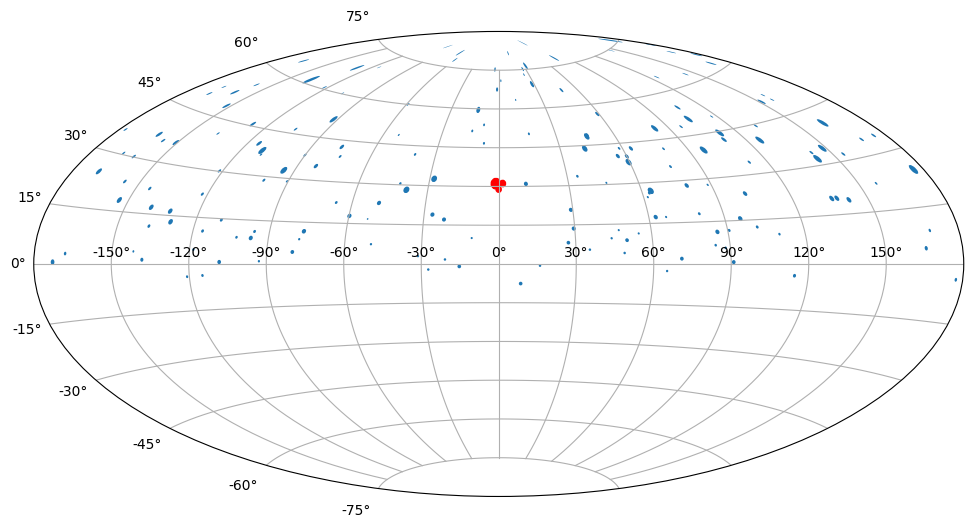

In [17]:
# Plot directions
ps_sel = events.source_label["IC86_II"] == 1

fig, ax = plt.subplots(subplot_kw={"projection": "aitoff"})
fig.set_size_inches((12, 7))

circles = []
for r, d, a in zip(
    events.ra["IC86_II"][~ps_sel],
    events.dec["IC86_II"][~ps_sel],
    events.ang_err["IC86_II"][~ps_sel],
):
    circle = Circle((r - np.pi, d), radius=np.deg2rad(a))
    circles.append(circle)
df_nu = PatchCollection(circles)

circles = []
for r, d, a in zip(
    events.ra["IC86_II"][ps_sel],
    events.dec["IC86_II"][ps_sel],
    events.ang_err["IC86_II"][ps_sel],
):
    circle = Circle((r - np.pi, d), radius=np.deg2rad(a))
    circles.append(circle)
ps_nu = PatchCollection(circles, color="r")

ax.add_collection(df_nu)
ax.add_collection(ps_nu)

ax.grid()
fig.savefig("example_simulation.png", dpi=150)

# Time dependent simulation

We can simulate an observation campaign spanning multiple data periods of IceCube through a "meta class" `TimeDependentSimulator`:

In [18]:
tsim = TimeDependentSimulator(["IC86_I", "IC86_II"], sources)

/opt/hostedtoolcache/Python/3.9.20/x64/lib/python3.9/site-packages/icecube_tools/detector/r2021.py:89: RuntimeWarning: divide by zero encountered in log10
  self.dataset[:, 6:-1] = np.log10(self.dataset[:, 6:-1])


Empty true energy bins at: [(0, 0), (1, 0)]


Need to set simulation times, defaults to 1 year each.


We need to set simulation times for all periods. Since for past periods the simulation time shouldn't be larger than the actual observation time (that is time span - down time of the detector) we need to take care, or rather, we let the class `Uptime` take care:

In [19]:
from icecube_tools.utils.data import Uptime

It lets us calculate the actual observation time through, e.g. IC86_II, vs the time covered:

In [20]:
uptime = Uptime("IC86_I", "IC86_II")
uptime._time_obs("IC86_II"), uptime.time_span()["IC86_II"]

(0.9089039325939252, 1.0157235341273203)

We can further define a start and end time of an observation and let it calculate the observation time in each period. Viable possible options are
 - start and end time in MJD
 - start time in MJD and duration in years
 - end time in MJD and duration in years

If the start time is before the earliest period (IC_40), the start time will be set to the earliest possible date.

If the end time is past the last period (IC86_II), then we get an according message and simulate into the future.

We can of course bypass this time setting and operate directly on the instances of Simulator, for example if we'd want to build up large statistics for subsequent likelihood analysis.

In [21]:
times = uptime.find_obs_time(start=55869, duration=3)
times

{'IC86_I': 0.4798785512080253, 'IC86_II': 2.425230588331747}

The returned dictionary can be used to set the simulation times for an instance of `TimeDependentSimulator`:

In [22]:
tsim.time = times

The simulation is started by calling `run()`, results can be saved by `save(file_prefix)`, with the filename being `{file_prefix}_{p}.h5` with period `p`.

In [23]:
tsim.run(show_progress=True)

Sampling:   0%|          | 0/94 [00:00<?, ?it/s]

Sampling:   6%|▋         | 6/94 [00:00<00:01, 59.11it/s]

Sampling:  32%|███▏      | 30/94 [00:00<00:00, 147.52it/s]

Sampling:  61%|██████    | 57/94 [00:00<00:00, 196.07it/s]

Sampling: 100%|██████████| 94/94 [00:00<00:00, 260.04it/s]

Sampling: 100%|██████████| 94/94 [00:00<00:00, 156.24it/s]

Sampling:   0%|          | 0/486 [00:00<?, ?it/s]

Sampling:   8%|▊         | 41/486 [00:00<00:01, 310.97it/s]

Sampling:  16%|█▋        | 80/486 [00:00<00:01, 318.46it/s]

Sampling:  34%|███▍      | 166/486 [00:00<00:00, 522.32it/s]

Sampling:  49%|████▉     | 237/486 [00:00<00:00, 554.42it/s]

Sampling:  67%|██████▋   | 324/486 [00:00<00:00, 602.37it/s]

Sampling: 100%|██████████| 486/486 [00:01<00:00, 413.76it/s]

In [24]:
tsim._true_energy

{'IC86_I': array([  188.64565779,  2838.69103169,   367.03045702,   302.86551638,
         4041.54858527,   104.56850236,   522.75467614,   426.24773827,
          484.33570281,   914.37828968,   284.48042369,   385.77928756,
          305.09653451,   512.22894559,  4033.68565151,   827.09079631,
         1059.19680016,   345.38516511,   685.74336857,   278.77527675,
          117.99690533,   110.32573334,  1802.52451934,   778.4410995 ,
          161.31934235,   423.99437872, 41263.84753565,   570.86216909,
          620.64780466,   597.79735352,   957.76179785,   694.11484137,
          184.95209007,   309.86561253,   116.95305688,   501.14146051,
         2932.71252223,   147.56917441,  1447.49260734,   457.06727436,
          404.93199983,   750.86366987,   247.89242896,   127.09485487,
          305.99211461,   129.49500423,   182.51651381,  1066.13998262,
          261.69269187,   641.28701347,   650.12902535,   164.81450688,
          163.53010379,  1029.08167752,   450.77505447

In [25]:
tsim.write_to_h5("multi_test.hdf5", sources)

In [26]:
tsim.arrival_energy

{'IC86_I': array([  188.64565779,  2838.69103169,   367.03045702,   302.86551638,
         4041.54858527,   104.56850236,   522.75467614,   426.24773827,
          484.33570281,   914.37828968,   284.48042369,   385.77928756,
          305.09653451,   512.22894559,  4033.68565151,   827.09079631,
         1059.19680016,   345.38516511,   685.74336857,   278.77527675,
          117.99690533,   110.32573334,  1802.52451934,   778.4410995 ,
          161.31934235,   423.99437872, 41263.84753565,   570.86216909,
          620.64780466,   597.79735352,   957.76179785,   694.11484137,
          184.95209007,   309.86561253,   116.95305688,   501.14146051,
         2932.71252223,   147.56917441,  1447.49260734,   457.06727436,
          404.93199983,   750.86366987,   247.89242896,   127.09485487,
          305.99211461,   129.49500423,   182.51651381,  1066.13998262,
          261.69269187,   641.28701347,   650.12902535,   164.81450688,
          163.53010379,  1029.08167752,   450.77505447

In [27]:
events = SimEvents.load_from_h5("multi_test.hdf5")

In [28]:
events.arrival_energy

{'IC86_I': array([  188.64565779,  2838.69103169,   367.03045702,   302.86551638,
         4041.54858527,   104.56850236,   522.75467614,   426.24773827,
          484.33570281,   914.37828968,   284.48042369,   385.77928756,
          305.09653451,   512.22894559,  4033.68565151,   827.09079631,
         1059.19680016,   345.38516511,   685.74336857,   278.77527675,
          117.99690533,   110.32573334,  1802.52451934,   778.4410995 ,
          161.31934235,   423.99437872, 41263.84753565,   570.86216909,
          620.64780466,   597.79735352,   957.76179785,   694.11484137,
          184.95209007,   309.86561253,   116.95305688,   501.14146051,
         2932.71252223,   147.56917441,  1447.49260734,   457.06727436,
          404.93199983,   750.86366987,   247.89242896,   127.09485487,
          305.99211461,   129.49500423,   182.51651381,  1066.13998262,
          261.69269187,   641.28701347,   650.12902535,   164.81450688,
          163.53010379,  1029.08167752,   450.77505447

In [29]:
"""
for i in [3.9]:
    norm_energy = 1e5 # Energy of normalisation in units of GeV
    min_energy = 1e2 # GeV
    max_energy = 1e8 # GeV
    phi_solver = PhiSolver(aeff, norm_energy, min_energy, max_energy, 
                           time=1, min_cosz=-1, max_cosz=1)
    phi_norm = phi_solver(Nnu=2000, 
                          dec=30, # degrees
                          index=i) # spectral index
    phi_norm # GeV^-1 cm^-2 s^-1
    point_power_law = PowerLawFlux(phi_norm, norm_energy, i, 
                                   min_energy, max_energy)
    point_source = PointSource(point_power_law, z=0., coord=(np.pi, np.deg2rad(30)))
    sources = [point_source]
    tsim = TimeDependentSimulator(["IC86_I", "IC86_II"], sources)
    for sim in tsim.simulators.values():
        sim.time = 1
    tsim.run(show_progress=True)
    tsim.save(f"index_{i}")
"""

'\nfor i in [3.9]:\n    norm_energy = 1e5 # Energy of normalisation in units of GeV\n    min_energy = 1e2 # GeV\n    max_energy = 1e8 # GeV\n    phi_solver = PhiSolver(aeff, norm_energy, min_energy, max_energy, \n                           time=1, min_cosz=-1, max_cosz=1)\n    phi_norm = phi_solver(Nnu=2000, \n                          dec=30, # degrees\n                          index=i) # spectral index\n    phi_norm # GeV^-1 cm^-2 s^-1\n    point_power_law = PowerLawFlux(phi_norm, norm_energy, i, \n                                   min_energy, max_energy)\n    point_source = PointSource(point_power_law, z=0., coord=(np.pi, np.deg2rad(30)))\n    sources = [point_source]\n    tsim = TimeDependentSimulator(["IC86_I", "IC86_II"], sources)\n    for sim in tsim.simulators.values():\n        sim.time = 1\n    tsim.run(show_progress=True)\n    tsim.save(f"index_{i}")\n'